## Linear regression (Baseline)
1. Load data and drop colinear features based on feature engineering (no need to define timesplits as no hyperparameteres need to be tuned)
2. Train model and produce theta parameters
3. Test on unseen data
4. Compare and state differences

### Section 1: Load and Prepare Data

In [1]:
# --- STEP 1: Load and prepare data for Regularized Regression ---

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the latest cleaned training dataset
train_df = pd.read_csv("data/final_data_train.csv", parse_dates=["ts"])
train_df = train_df.sort_values("ts").reset_index(drop=True)

# === Updated feature selection based on feature analysis ===
selected_features = [
    "power",  # target
    # --- Wind features ---
    "mean_wind_speed_Nex",
    "mean_wind_speed_Hammer_ Odde_Fyr",
    # --- Temperature ---
    "mean_temp_Hammer_Odde_Fyr",
    # --- Market prices ---
    "DK2_DKK",
    "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK",
    "BalancingPowerPriceDownDKK",
    # --- Temporal features ---
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "dayofweek"
]

data = train_df[selected_features].copy()

# Split into predictors and target
target_col = "power"
X = data.drop(columns=[target_col]).values
y = data[target_col].values
feature_names = data.drop(columns=[target_col]).columns.tolist()

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Scaled feature matrix shape: {X_scaled.shape}")
print("Features used:", feature_names)

Scaled feature matrix shape: (22422, 12)
Features used: ['mean_wind_speed_Nex', 'mean_wind_speed_Hammer_ Odde_Fyr', 'mean_temp_Hammer_Odde_Fyr', 'DK2_DKK', 'ImbalancePriceDKK', 'BalancingPowerPriceUpDKK', 'BalancingPowerPriceDownDKK', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dayofweek']


In [17]:
# --- STEP 2: Load and prepare test data (same features, same scaling) ---

# Load and sort test data
test_df = pd.read_csv("data/final_data_test.csv", parse_dates=["ts"])
test_df = test_df.sort_values("ts").reset_index(drop=True)

# Select same columns as in training
test_data = test_df[selected_features].copy()

# Split into X and y
X_test = scaler.transform(test_data.drop(columns=["power"]).values)
y_test = test_data["power"].values

print(f"Test set shape: {X_test.shape}")

Test set shape: (7892, 12)


### Section 2 & 3: Train and produce theta/ Test

In [18]:
# --- STEP X: Closed-form Linear Regression (no sklearn) ---

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Add intercept term manually
X_train_cf = np.c_[np.ones(X_scaled.shape[0]), X_scaled]
X_test_cf  = np.c_[np.ones(X_test.shape[0]), X_test]

# === Closed-form solution ===
# β̂ = (XᵀX)⁻¹ Xᵀy
beta_hat = np.linalg.inv(X_train_cf.T @ X_train_cf) @ X_train_cf.T @ y

# === Predictions ===
y_train_pred_cf = X_train_cf @ beta_hat
y_test_pred_cf  = X_test_cf @ beta_hat

# Clip negative predictions
y_train_pred_cf = np.clip(y_train_pred_cf, 0, None)
y_test_pred_cf  = np.clip(y_test_pred_cf, 0, None)

# === Evaluate ===
rmse_train_cf = np.sqrt(mean_squared_error(y, y_train_pred_cf))
rmse_test_cf  = np.sqrt(mean_squared_error(y_test, y_test_pred_cf))
r2_train_cf   = r2_score(y, y_train_pred_cf)
r2_test_cf    = r2_score(y_test, y_test_pred_cf)

print("📘 Closed-form Linear Regression (Normal Equation)")
print(f"   Train RMSE = {rmse_train_cf:.4f}, R² = {r2_train_cf:.4f}")
print(f"   Test  RMSE = {rmse_test_cf:.4f}, R² = {r2_test_cf:.4f}")

# --- Compare coefficients to sklearn model ---
coef_cf = beta_hat[1:]
intercept_cf = beta_hat[0]

📘 Closed-form Linear Regression (Normal Equation)
   Train RMSE = 0.3068, R² = 0.7309
   Test  RMSE = 0.4593, R² = -0.1332


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- Fit simple Linear Regression on all training data ---
linreg = LinearRegression()
linreg.fit(X_scaled, y)

# --- Predict on both train and test ---
y_train_pred_lin = linreg.predict(X_scaled)
y_test_pred_lin  = linreg.predict(X_test)

# --- Clip negative predictions ---
y_train_pred_lin = np.clip(y_train_pred_lin, 0, None)
y_test_pred_lin  = np.clip(y_test_pred_lin, 0, None)

# --- Evaluate statistical metrics ---
rmse_train = np.sqrt(mean_squared_error(y, y_train_pred_lin))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred_lin))
r2_train   = r2_score(y, y_train_pred_lin)
r2_test    = r2_score(y_test, y_test_pred_lin)

print(f"📊 Linear Regression Performance:")
print(f"   Train RMSE = {rmse_train:.4f}, R² = {r2_train:.4f}")
print(f"   Test  RMSE = {rmse_test:.4f}, R² = {r2_test:.4f}")

📊 Linear Regression Performance:
   Train RMSE = 0.3068, R² = 0.7309
   Test  RMSE = 0.4593, R² = -0.1332


extract coeffs and visualize

Intercept (β₀): 0.5322



,Coefficient
mean_wind_speed_Nex,0.358892
mean_wind_speed_Hammer_ Odde_Fyr,0.160567
DK2_DKK,-0.061528
hour_cos,0.051361
ImbalancePriceDKK,-0.046208
BalancingPowerPriceUpDKK,0.038105
BalancingPowerPriceDownDKK,0.025433
hour_sin,0.016463
dow_cos,-0.004113
mean_temp_Hammer_Odde_Fyr,-0.001914


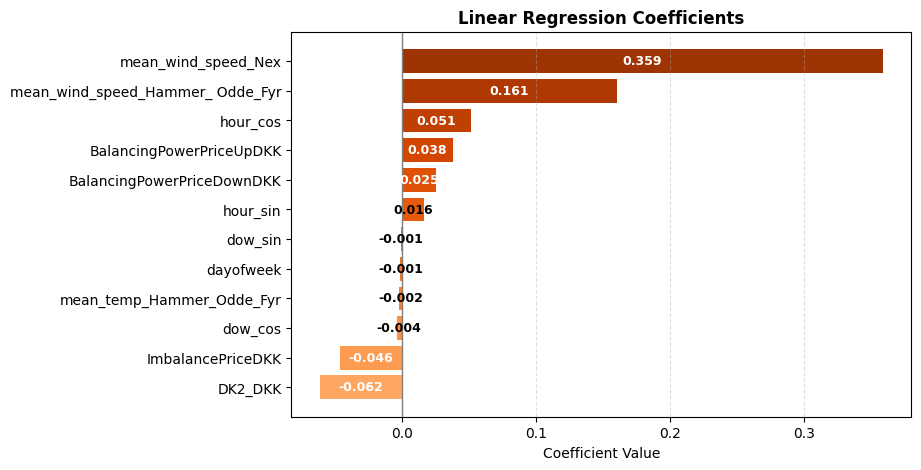

In [20]:
# --- Extract coefficients ---
coef_series_lin = pd.Series(linreg.coef_, index=feature_names)

# --- Add intercept separately ---
print(f"Intercept (β₀): {linreg.intercept_:.4f}\n")

# --- Display sorted coefficients ---
coef_series_lin = coef_series_lin.sort_values(key=abs, ascending=False)
display(coef_series_lin.to_frame("Coefficient"))

plt.figure(figsize=(8, 5))
coef_series_sorted = coef_series_lin.sort_values()

bars = plt.barh(
    coef_series_sorted.index,
    coef_series_sorted.values,
    color=plt.cm.Oranges(np.linspace(0.4, 0.9, len(coef_series_sorted)))
)

# Label coefficients inside bars
for bar in bars:
    width = bar.get_width()
    label_color = "white" if abs(width) > 0.02 else "black"
    plt.text(
        width / 2,
        bar.get_y() + bar.get_height()/2,
        f"{width:.3f}",
        ha='center', va='center',
        fontsize=9, color=label_color, weight='bold'
    )

plt.axvline(0, color='gray', linewidth=1)
plt.title("Linear Regression Coefficients", fontsize=12, weight='bold')
plt.xlabel("Coefficient Value")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout
plt.show()

## Section 4: Visualzie resutls

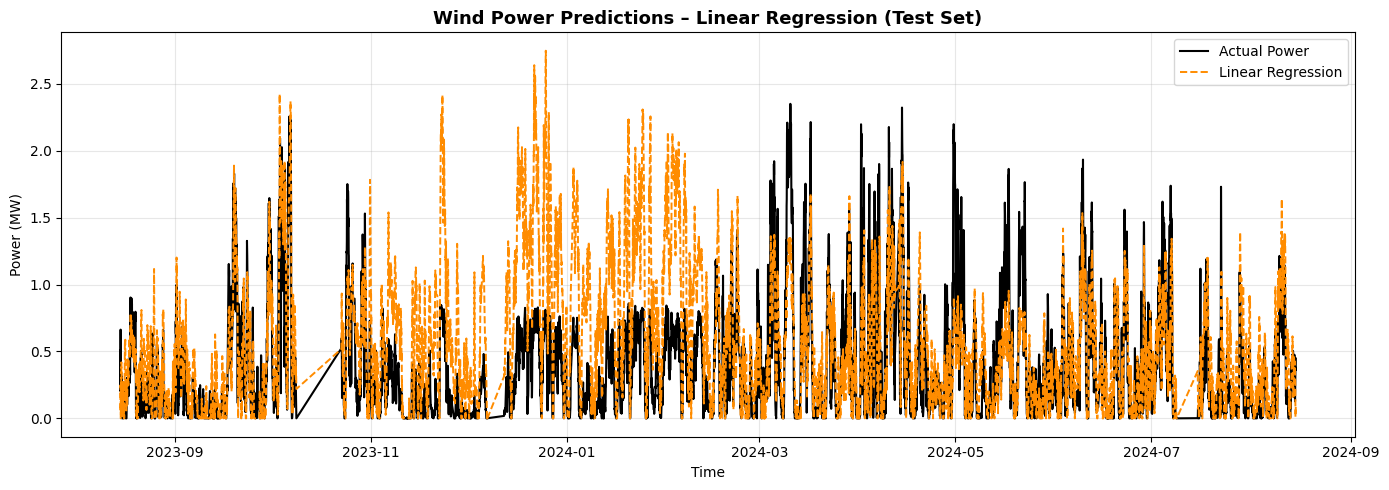

In [6]:
# --- Create DataFrame with actual and predicted test results ---
results_plot = pd.DataFrame({
    "ts": test_df["ts"],
    "Actual": y_test,
    "Linear": y_test_pred_lin
})

# --- Plot time series comparison (entire test set) ---
plt.figure(figsize=(14, 5))
plt.plot(results_plot["ts"], results_plot["Actual"], "k-", label="Actual Power", linewidth=1.5)
plt.plot(results_plot["ts"], results_plot["Linear"], color="darkorange", linestyle="--", label="Linear Regression", linewidth=1.4)

plt.title("Wind Power Predictions – Linear Regression (Test Set)", fontsize=13, weight="bold")
plt.xlabel("Time")
plt.ylabel("Power (MW)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# --- Extract time components ---
results_plot["year"] = results_plot["ts"].dt.year
results_plot["month"] = results_plot["ts"].dt.month
results_plot["week"] = results_plot["ts"].dt.isocalendar().week

# --- Compute monthly RMSE ---
monthly_rmse = results_plot.groupby(["year", "month"]).apply(
    lambda df: pd.Series({
        "Linear_RMSE": np.sqrt(mean_squared_error(df["Actual"], df["Linear"]))
    })
).reset_index()

# Identify best and worst months
best_month = monthly_rmse.loc[monthly_rmse["Linear_RMSE"].idxmin()]
worst_month = monthly_rmse.loc[monthly_rmse["Linear_RMSE"].idxmax()]

print("✅ Best month:", best_month.to_dict())
print("❌ Worst month:", worst_month.to_dict())

# --- Compute weekly RMSE (optional diagnostic) ---
weekly_rmse = results_plot.groupby(["year", "week"]).apply(
    lambda df: pd.Series({
        "Linear_RMSE": np.sqrt(mean_squared_error(df["Actual"], df["Linear"]))
    })
).reset_index()

worst_week = weekly_rmse.loc[weekly_rmse["Linear_RMSE"].idxmax()]
print("⚠️  Worst week:", worst_week.to_dict())

✅ Best month: {'year': 2023.0, 'month': 8.0, 'Linear_RMSE': 0.22795530719046747}
❌ Worst month: {'year': 2023.0, 'month': 12.0, 'Linear_RMSE': 0.7836745081674579}
⚠️  Worst week: {'year': 2023.0, 'week': 51.0, 'Linear_RMSE': 0.9234453331506589}


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31331/3491756849.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_rmse = results_plot.groupby(["year", "month"]).apply(
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31331/3491756849.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_rmse = results_plot.groupby(["year", "week"]).apply(


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31331/2776731092.py:15: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jonaswiendl/local/Repos/assignment-1-awesome/ml_assignment1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


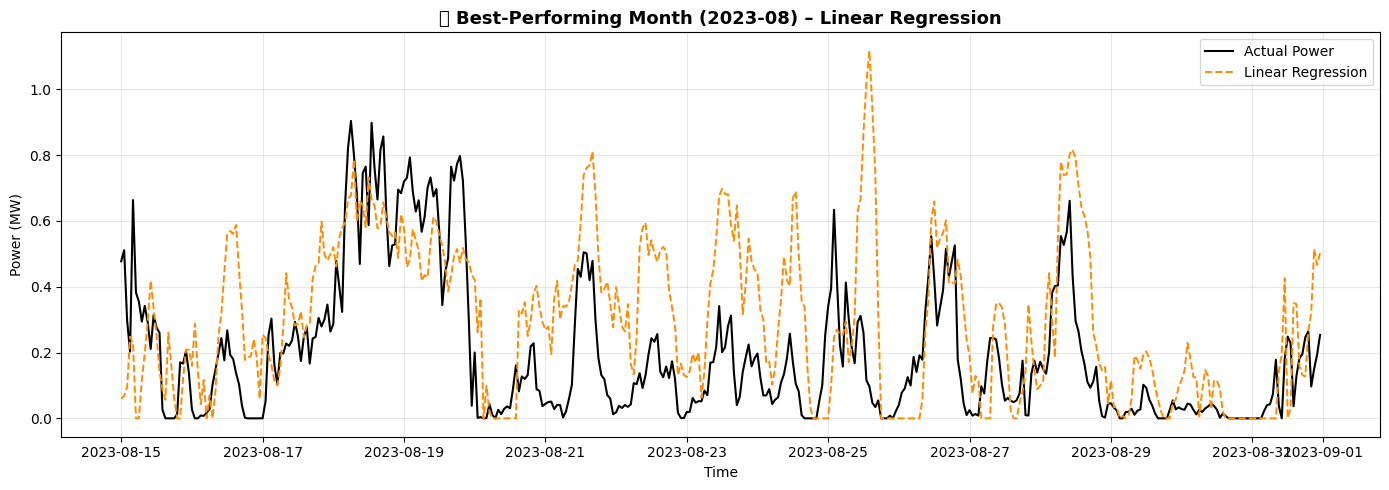

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_31331/2776731092.py:15: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jonaswiendl/local/Repos/assignment-1-awesome/ml_assignment1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


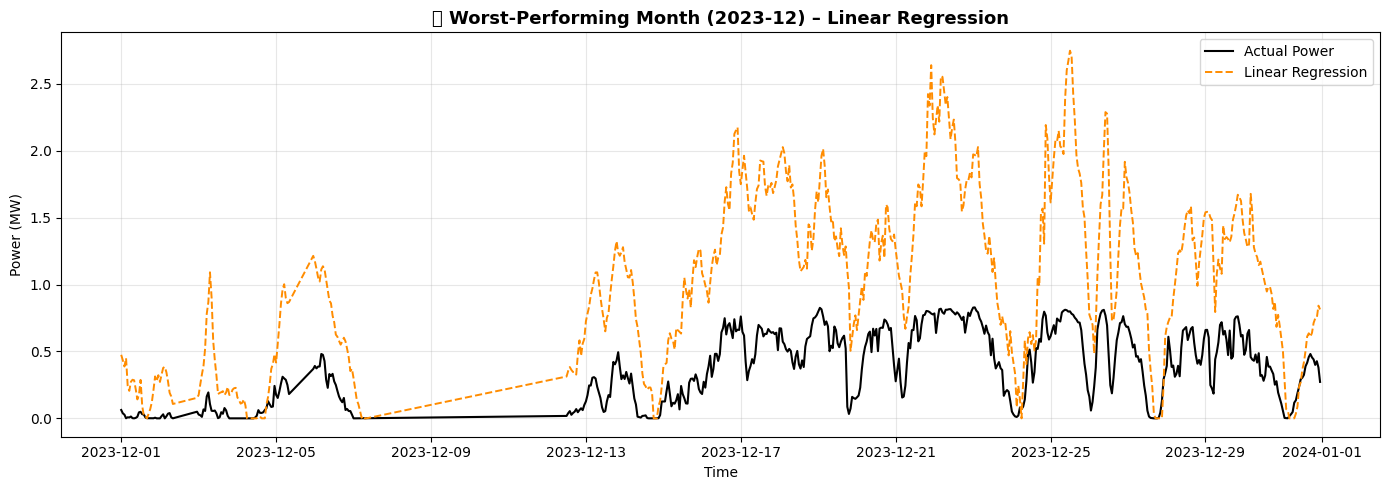

In [8]:
def plot_month(df, year, month, title):
    """Plot actual vs predicted power for a given month."""
    month_data = df[(df["ts"].dt.year == year) & (df["ts"].dt.month == month)].copy()
    if month_data.empty:
        print(f"No data for {year}-{month}")
        return
    plt.figure(figsize=(14, 5))
    plt.plot(month_data["ts"], month_data["Actual"], "k-", label="Actual Power", linewidth=1.5)
    plt.plot(month_data["ts"], month_data["Linear"], color="darkorange", linestyle="--", label="Linear Regression", linewidth=1.4)
    plt.title(title, fontsize=13, weight="bold")
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Plot best and worst months ---
plot_month(results_plot, int(best_month["year"]), int(best_month["month"]),
           f"✅ Best-Performing Month ({int(best_month['year'])}-{int(best_month['month']):02d}) – Linear Regression")

plot_month(results_plot, int(worst_month["year"]), int(worst_month["month"]),
           f"❌ Worst-Performing Month ({int(worst_month['year'])}-{int(worst_month['month']):02d}) – Linear Regression")


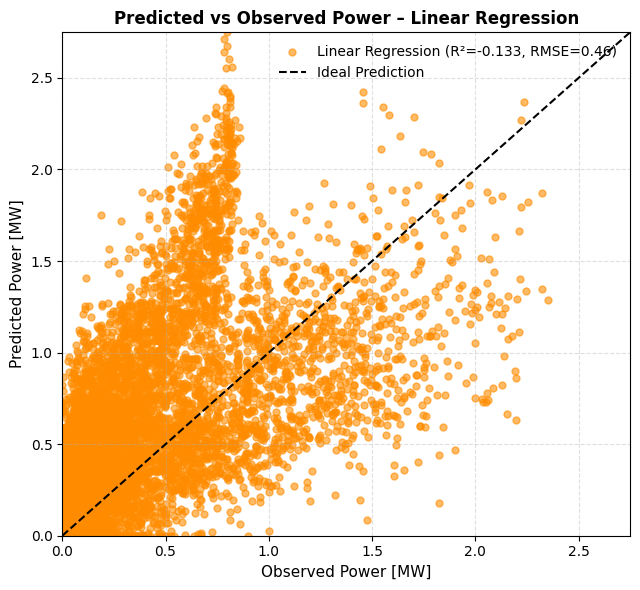

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

# --- Compute R² for context ---
r2_lin = r2_score(y_test, y_test_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_test_pred_lin))

# --- Axis limits ---
min_val = min(y_test.min(), y_test_pred_lin.min())
max_val = max(y_test.max(), y_test_pred_lin.max())
lims = [min_val, max_val]

# --- Scatter plot ---
plt.figure(figsize=(6.5, 6))
plt.scatter(y_test, y_test_pred_lin, alpha=0.6, s=25,
            color="darkorange", label=f"Linear Regression (R²={r2_lin:.3f}, RMSE={rmse_lin:.2f})")

# --- Diagonal reference line (perfect prediction) ---
plt.plot(lims, lims, 'k--', lw=1.5, label="Ideal Prediction")

# --- Axis styling ---
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Observed Power [MW]", fontsize=11)
plt.ylabel("Predicted Power [MW]", fontsize=11)
plt.title("Predicted vs Observed Power – Linear Regression", fontsize=12, weight='bold')
plt.legend(frameon=False, fontsize=10)
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()


In [10]:
def profit(p_commit, p_real, price_da, price_up, price_down):
    """
    Compute total profit for a set of decisions and prices.

    Parameters
    ----------
    p_commit : np.ndarray
        Committed power in the day-ahead market (decision variable, can be continuous between 0 and capacity).
    p_real : np.ndarray
        Realized wind production (truth).
    price_da : np.ndarray
        Day-ahead price (DKK/MWh).
    price_up : np.ndarray
        Up-regulation price (DKK/MWh).
    price_down : np.ndarray
        Down-regulation price (DKK/MWh).

    Returns
    -------
    float
        total profit over all time steps.
    """
    # Positive imbalance: produced more than committed (sell extra at down price)
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    # Negative imbalance: produced less than committed (buy shortage at up price)
    imbalance_neg = np.maximum(p_commit - p_real, 0)

    R_D = np.sum(price_da * p_commit)
    R_B = np.sum(price_down * imbalance_pos - price_up * imbalance_neg)

    return R_D + R_B

# Compute instantaneous profits (hourly or timestep-based)
def profit_series(p_commit, p_real, price_da, price_up, price_down):
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    imbalance_neg = np.maximum(p_commit - p_real, 0)
    R_D = price_da * p_commit
    R_B = price_down * imbalance_pos - price_up * imbalance_neg
    return R_D + R_B  # array of profit per timestep


In [11]:
# === TRAIN PERIOD ===
price_DA_train   = train_df["DK2_DKK"].values
price_UP_train   = train_df["BalancingPowerPriceUpDKK"].values
price_DOWN_train = train_df["BalancingPowerPriceDownDKK"].values
p_real_train     = train_df["power"].values

# Predictions (already fitted)
y_pred_lin_train = linreg.predict(X_scaled)
y_pred_lin_train = np.clip(y_pred_lin_train, 0, None)

# Profits
profit_real_train = profit(p_real_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)
profit_lin_train  = profit(y_pred_lin_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)


# === TEST PERIOD ===
price_DA_test   = test_df["DK2_DKK"].values
price_UP_test   = test_df["BalancingPowerPriceUpDKK"].values
price_DOWN_test = test_df["BalancingPowerPriceDownDKK"].values
p_real_test     = test_df["power"].values

y_pred_lin_test = linreg.predict(X_test)
y_pred_lin_test = np.clip(y_pred_lin_test, 0, None)

profit_real_test = profit(p_real_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_lin_test  = profit(y_pred_lin_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)


# === SUMMARY TABLE ===
summary = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Perfect Info (Real Power)": [profit_real_train, profit_real_test],
    "Linear Regression": [profit_lin_train, profit_lin_test],
})

summary["Linear / Perfect [%]"] = 100 * summary["Linear Regression"] / summary["Perfect Info (Real Power)"]

# Display nicely
display(summary.round(2))

,Dataset,Perfect Info (Real Power),Linear Regression,Linear / Perfect [%]
0,Train,7911643.12,7391686.02,93.43
1,Test,1082036.68,854295.03,78.95


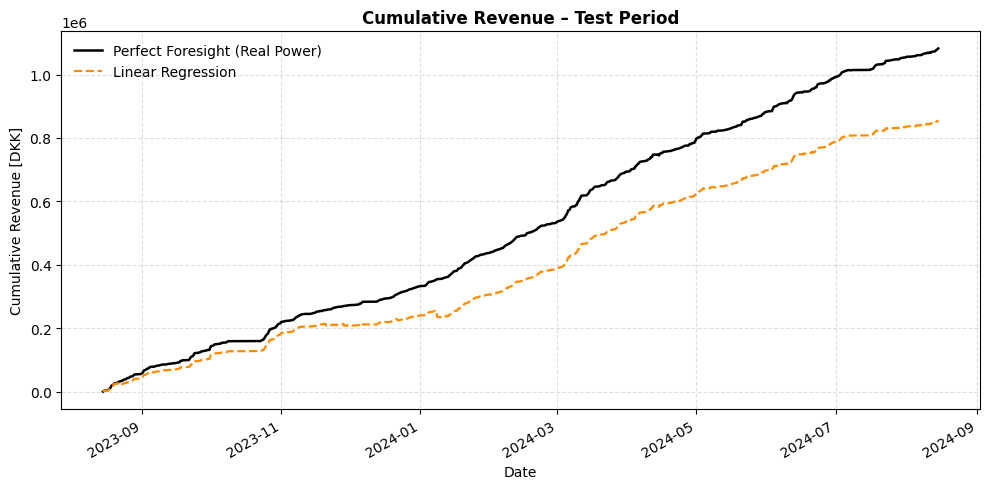

In [12]:
# --- Compute per-timestep profit ---
profit_real_ts = profit_series(p_real_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_lin_ts  = profit_series(y_pred_lin_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)

# --- Cumulative revenue dataframe ---
rev_df = pd.DataFrame({
    "Date": test_df["ts"],
    "Perfect Foresight": np.cumsum(profit_real_ts),
    "Linear Regression": np.cumsum(profit_lin_ts)
})

# --- Plot cumulative revenue ---
plt.figure(figsize=(10,5))
plt.plot(rev_df["Date"], rev_df["Perfect Foresight"], color="black", lw=1.8, label="Perfect Foresight (Real Power)")
plt.plot(rev_df["Date"], rev_df["Linear Regression"], color="darkorange", lw=1.6, linestyle="--", label="Linear Regression")

plt.title("Cumulative Revenue – Test Period", fontsize=12, weight='bold')
plt.xlabel("Date")
plt.ylabel("Cumulative Revenue [DKK]")
plt.legend(frameon=False)
plt.grid(alpha=0.4, linestyle='--')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

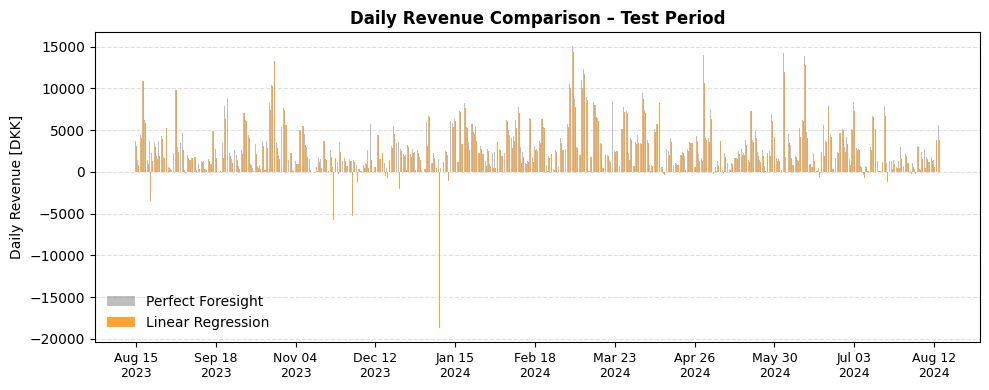

In [13]:
# --- Aggregate daily revenue ---
rev_daily = pd.DataFrame({
    "Date": pd.to_datetime(test_df["ts"]).dt.normalize(),  # ensure date-only
    "Perfect Foresight": profit_real_ts,
    "Linear Regression": profit_lin_ts
}).groupby("Date").sum().reset_index()

# --- Plot ---
plt.figure(figsize=(10, 4))

bar_width = 0.4
x = np.arange(len(rev_daily))

plt.bar(x - bar_width/2, rev_daily["Perfect Foresight"], width=bar_width,
        color="gray", alpha=0.5, label="Perfect Foresight")
plt.bar(x + bar_width/2, rev_daily["Linear Regression"], width=bar_width,
        color="darkorange", alpha=0.8, label="Linear Regression")

plt.title("Daily Revenue Comparison – Test Period", fontsize=12, weight='bold')
plt.ylabel("Daily Revenue [DKK]")
plt.legend(frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# --- Format X-axis with fewer ticks ---
plt.xticks(
    x[::max(1, len(x)//10)],
    [d.strftime("%b %d\n%Y") for d in rev_daily["Date"][::max(1, len(x)//10)]],
    rotation=0, ha="center", fontsize=9
)

plt.tight_layout()
plt.show()

In [14]:
# --- FINAL OUTPUT BLOCK FOR MASTER COMPARISON ---

test_results = {
    "model_name": "Baseline Linear",        # change per notebook
    "y_test": p_real_test,                       # true test values
    "y_test_pred": y_pred_lin_test,             # predicted test values
    "test_rmse": rmse_test,                 # test RMSE value
}

print(f"✅ Saved test_results for {test_results['model_name']}")

✅ Saved test_results for Baseline Linear


In [15]:
# --- Export Results for Baseline Linear ---
import pandas as pd, os

os.makedirs("Results", exist_ok=True)

# Save full test predictions
pd.DataFrame({
    "ts": test_df["ts"],
    "y_test": test_results["y_test"],
    "y_pred": test_results["y_test_pred"]
}).to_csv("Results/baseline_linear_predictions.csv", index=False)

# Save summary metrics
pd.DataFrame([{
    "model": test_results["model_name"],
    "test_rmse": float(test_results["test_rmse"])
}]).to_csv("Results/baseline_linear_summary.csv", index=False)

print("✅ Exported Baseline Linear results to 'Results/' folder.")

✅ Exported Baseline Linear results to 'Results/' folder.
